# Week 1 - Tokenization and Representation

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
sentences = [
    "I love my dog",
    "I love my cat",
    "You love my dog!",
    "Do you think my do is amazing?"
]

tokenizer = Tokenizer(num_words = 100, oov_token = "<OOV>") # num_words - maximum number of words to keep
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
# padded = pad_sequences(sequences)
padded = pad_sequences(sequences, padding='post', truncating = 'post', maxlen = 5)

In [3]:
print(word_index)

{'<OOV>': 1, 'my': 2, 'love': 3, 'i': 4, 'dog': 5, 'you': 6, 'do': 7, 'cat': 8, 'think': 9, 'is': 10, 'amazing': 11}


In [4]:
print(sequences)

[[4, 3, 2, 5], [4, 3, 2, 8], [6, 3, 2, 5], [7, 6, 9, 2, 7, 10, 11]]


In [5]:
print(padded)

[[4 3 2 5 0]
 [4 3 2 8 0]
 [6 3 2 5 0]
 [7 6 9 2 7]]


In [6]:
test_data = [
    'i really love my dog',
    'my dog loves my manatee'
]

In [7]:
test_seq = tokenizer.texts_to_sequences(test_data)
test_padded = pad_sequences(test_seq, maxlen = 10)

In [8]:
print(test_seq)

[[4, 1, 3, 2, 5], [2, 5, 1, 2, 1]]


In [9]:
print(test_padded)

[[0 0 0 0 0 4 1 3 2 5]
 [0 0 0 0 0 2 5 1 2 1]]


### Sarcasm Exercise

In [10]:
# Original Data found here:
# https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/home
# Had to edit the file using:
# sed 's/{/,{/' Sarcasm_Headlines_Dataset.json > Sarcasm_Headlines_Dataset_edited_3.json 
# and then added the squuare bracket to make it a list.

import json
with open("Sarcasm_Headlines_Dataset_edited_3.json") as f:
    datastore = json.load(f)

In [11]:
sentences = []
labels = []
urls = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
tokenizer = Tokenizer(oov_token = '<OOV>')
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post')

Note: word_index above will include all words that tokenizer has seen even if num_words were specified in the Tokenizer's constructor. When it takes the top num_words, it does that in text_to_sequences() 

In [14]:
print(padded[0])
print(padded.shape)

[  308 15115   679  3337  2298    48   382  2576 15116     6  2577  8434
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
(26709, 40)


# Week 2

## Using IMDB Review to extract embedding layer

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
# tf.enable_eaguer_execution() # for TF v2 below
#!pip install -q tensorflow_datasets

In [4]:
import tensorflow_datasets as tfds

In [5]:
imdb, info = tfds.load("imdb_reviews", with_info = True, as_supervised = True)

In [6]:
import numpy as np
train_data, test_data = imdb['train'], imdb['test']

In [7]:
train_data

<_OptionsDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [8]:
iter(train_data).next()[0].numpy().decode('utf8')

'I have no idea what the other reviewer is talking about- this was a wonderful movie, and created a sense of the era that feels like time travel. The characters are truly young, Mary is a strong match for Byron, Claire is juvenile and a tad annoying, Polidori is a convincing beaten-down sycophant... all are beautiful, curious, and decadent... not the frightening wrecks they are in Gothic.<br /><br />Gothic works as an independent piece of shock film, and I loved it for different reasons, but this works like a Merchant and Ivory film, and was from my readings the best capture of what the summer must have felt like. Romantic, yes, but completely rekindles my interest in the lives of Shelley and Byron every time I think about the film. One of my all-time favorites.'

In [9]:
iter(train_data).next()[1].numpy()

1

In [10]:
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []

In [11]:
for s, l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

In [12]:
for s, l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

In [13]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [14]:
testing_labels_final

array([1, 1, 1, ..., 1, 1, 1])

In [15]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = "<OOV>"

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences= tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(), # tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [20]:
testing_labels_final

array([1, 1, 1, ..., 1, 1, 1])

In [21]:
num_epochs = 10
model.fit(padded, 
         training_labels_final, 
         epochs = num_epochs, 
         validation_data = (testing_padded, testing_labels_final))


Epoch 1/10
782/782 [==============================] - 2s 3ms/step - loss: 0.4941 - accuracy: 0.7414 - val_loss: 0.3413 - val_accuracy: 0.8497
Epoch 2/10
782/782 [==============================] - 2s 3ms/step - loss: 0.2458 - accuracy: 0.9047 - val_loss: 0.3583 - val_accuracy: 0.8438
Epoch 3/10
782/782 [==============================] - 2s 3ms/step - loss: 0.1063 - accuracy: 0.9704 - val_loss: 0.4351 - val_accuracy: 0.8318
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0288 - accuracy: 0.9959 - val_loss: 0.5347 - val_accuracy: 0.8268
Epoch 5/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0068 - accuracy: 0.9995 - val_loss: 0.5780 - val_accuracy: 0.8316
Epoch 6/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.6314 - val_accuracy: 0.8322
Epoch 7/10
782/782 [==============================] - 2s 3ms/step - loss: 9.6044e-04 - accuracy: 1.0000 - val_loss: 0.6760 - val_accuracy: 0.8329
Ep

In [22]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # (vocab size, embedding dim)

(10000, 16)


In [23]:
# Hello : 1 becomes 1 : Hello
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [24]:
weights

array([[-0.0312567 , -0.05944471,  0.01739567, ...,  0.00773264,
        -0.02007243,  0.00197575],
       [-0.05747269, -0.06633257, -0.05411755, ..., -0.03235354,
        -0.03521147,  0.05348418],
       [-0.10130357, -0.06131227,  0.01296134, ..., -0.04616608,
        -0.03516181,  0.03539503],
       ...,
       [-0.12904564,  0.03064172, -0.02822592, ...,  0.15442306,
         0.09250604,  0.05040063],
       [-0.04417039, -0.04587847,  0.05408237, ...,  0.03720405,
         0.10188363, -0.01510269],
       [ 0.03405285,  0.03089446,  0.01249585, ..., -0.0474978 ,
         0.0170981 ,  0.08247335]], dtype=float32)

In [25]:
# Create files to view on tensorflow embeding projector
# https://projector.tensorflow.org

import io

out_v = io.open('vecs.tsv', 'w', encoding = 'utf-8')
out_m = io.open('meta.tsv', 'w', encoding = 'utf-8')

for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

## Sarcasm

In [55]:
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [56]:
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

In [57]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O ./data/sarcasm.json

--2020-06-23 11:33:30--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.14.208
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.14.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘./data/sarcasm.json’

./data/sarcasm.json 100%[===================>]   5.38M  3.62MB/s    in 1.5s    

2020-06-23 11:33:32 (3.62 MB/s) - ‘./data/sarcasm.json’ saved [5643545/5643545]



In [58]:
with open("./data/sarcasm.json", 'r') as f:
    datastore = json.load(f)
    
sentences = []
labels = []

for items in datastore:
    sentences.append(items['headline'])
    labels.append(items['is_sarcastic'])

In [59]:
training_sentences = np.array(sentences[0:training_size])
testing_sentences = np.array(sentences[training_size:])
training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])

In [60]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type )

In [61]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])


In [62]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [63]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [64]:
history = model.fit(training_padded, training_labels, epochs = num_epochs, 
                   validation_data = (testing_padded, testing_labels), verbose = 2)

Epoch 1/10
625/625 - 1s - loss: 0.5659 - accuracy: 0.6961 - val_loss: 0.3936 - val_accuracy: 0.8365
Epoch 2/10
625/625 - 1s - loss: 0.3097 - accuracy: 0.8757 - val_loss: 0.3423 - val_accuracy: 0.8569
Epoch 3/10
625/625 - 1s - loss: 0.2337 - accuracy: 0.9089 - val_loss: 0.3411 - val_accuracy: 0.8547
Epoch 4/10
625/625 - 1s - loss: 0.1889 - accuracy: 0.9276 - val_loss: 0.3609 - val_accuracy: 0.8518
Epoch 5/10
625/625 - 1s - loss: 0.1565 - accuracy: 0.9438 - val_loss: 0.3833 - val_accuracy: 0.8527
Epoch 6/10
625/625 - 1s - loss: 0.1333 - accuracy: 0.9521 - val_loss: 0.4156 - val_accuracy: 0.8460
Epoch 7/10
625/625 - 1s - loss: 0.1142 - accuracy: 0.9610 - val_loss: 0.4565 - val_accuracy: 0.8399
Epoch 8/10
625/625 - 1s - loss: 0.0984 - accuracy: 0.9682 - val_loss: 0.4918 - val_accuracy: 0.8398
Epoch 9/10
625/625 - 2s - loss: 0.0857 - accuracy: 0.9724 - val_loss: 0.5386 - val_accuracy: 0.8360
Epoch 10/10
625/625 - 1s - loss: 0.0742 - accuracy: 0.9765 - val_loss: 0.5796 - val_accuracy: 0.8337

In [65]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string , 'val_'+string])
    plt.show()

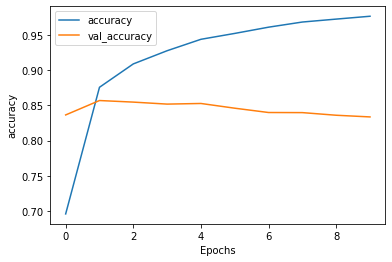

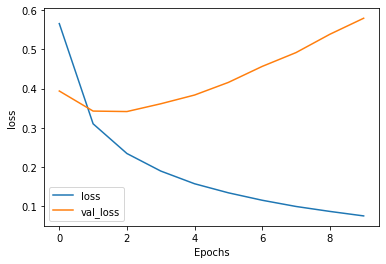

In [66]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Week 3


### LSTM
Back to the IMDB data

In [103]:
import tensorflow_datasets as tfds
import tensorflow as tf
print(tf.__version__)

2.2.0


In [104]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [105]:
tokenizer = info.features['text'].encoder

In [106]:
tokenizer

<SubwordTextEncoder vocab_size=8185>

In [107]:
tokenizer.vocab_size

8185

In [108]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

In [109]:
train_dataset # Note: we can pass this into model.fit insteady of separate numpy array for labels and data

<PaddedBatchDataset shapes: ((None, None), (None,)), types: (tf.int64, tf.int64)>

In [110]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    # Removing the Flatten and Pooling layer, and replaced with bidirectional LSTM
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [111]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [112]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [117]:
NUM_EPOCHS = 10
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 638s 2s/step - loss: 0.5029 - accuracy: 0.7547 - val_loss: 0.5530 - val_accuracy: 0.7106
Epoch 2/10
391/391 [==============================] - 619s 2s/step - loss: 0.5013 - accuracy: 0.7593 - val_loss: 0.5695 - val_accuracy: 0.7284
Epoch 3/10
391/391 [==============================] - 611s 2s/step - loss: 0.4791 - accuracy: 0.7769 - val_loss: 0.5826 - val_accuracy: 0.7179
Epoch 4/10
391/391 [==============================] - 600s 2s/step - loss: 0.3478 - accuracy: 0.8588 - val_loss: 0.4414 - val_accuracy: 0.8167
Epoch 5/10
391/391 [==============================] - 608s 2s/step - loss: 0.5405 - accuracy: 0.7243 - val_loss: 0.4882 - val_accuracy: 0.7844
Epoch 6/10
391/391 [==============================] - 607s 2s/step - loss: 0.2840 - accuracy: 0.8883 - val_loss: 0.3758 - val_accuracy: 0.8514
Epoch 7/10
391/391 [==============================] - 2726s 7s/step - loss: 0.2266 - accuracy: 0.9162 - val_loss: 0.3995 - val_accuracy: 0.840

In [118]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

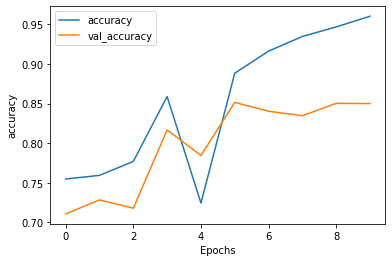

In [119]:
plot_graphs(history, 'accuracy')

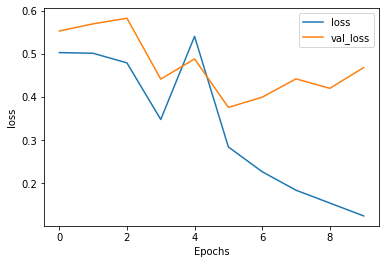

In [120]:
plot_graphs(history, 'loss')

In [ ]:
# 2 layers of LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Will take a very long time!
#NUM_EPOCHS = 10
#history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

In [ ]:
#plot_graphs(history, 'accuracy')

In [ ]:
#plot_graphs(history, 'loss')

### GRU and Convolution Model

In [121]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [122]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [123]:
# GRU
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 68s 87ms/step - loss: 0.5378 - accuracy: 0.6910 - val_loss: 0.3722 - val_accuracy: 0.8420
Epoch 2/50
782/782 [==============================] - 68s 86ms/step - loss: 0.3027 - accuracy: 0.8737 - val_loss: 0.3573 - val_accuracy: 0.8447
Epoch 3/50
782/782 [==============================] - 68s 86ms/step - loss: 0.2320 - accuracy: 0.9095 - val_loss: 0.4208 - val_accuracy: 0.8046
Epoch 4/50
782/782 [==============================] - 64s 82ms/step - loss: 0.1762 - accuracy: 0.9350 - val_loss: 0.4152 - val_accuracy: 0.8334
Epoch 5/50
782/782 [==============================] - 64s 82ms/step - loss: 0.1322 - accuracy: 0.9537 - val_loss: 0.5019 - val_accuracy: 0.8302
Epoch 6/50
782/782 [==============================] - 65s 83ms/step - loss: 0.0900 - accuracy: 0.9697 - val_loss: 0.5658 - val_accuracy: 0.8233
Epoch 7/50
782/782 [==============================] - 64s 82ms/step - loss: 0.0575 - accuracy: 0.9818 - val_loss: 0.7129 - val_accuracy:

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [85]:
# Convolution
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
3model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 128)           10368     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 774       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


### Sarcasm Dataset with Bidirectional LSTM

In [ ]:
import numpy as np

import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O ./data/sarcasm.json

vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


with open("./data/sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)


In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
model.save("sarcasm_lstm.h5")

### Sarcasm Dataset with Bidirectional Conv1D

In [ ]:
import numpy as np

import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)


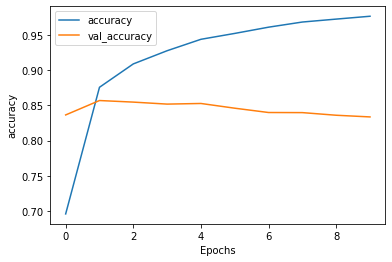

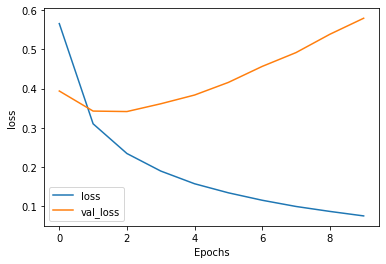

In [116]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
model.save("sarcasm_conv1d.h5")